
# Fundamentos de Deep Learning

Andres Felipe Osorio Henker

Universidad de Antioquia

Sistema de Predicción de futuras fallas en servidores de data centers basada en la telemetría

Exploración de los datos

In [5]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import linear_model
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM
from google.colab import drive
import tarfile

In [7]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__
from local.lib.DataPreparationRNN import split_sequence

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#with tarfile.open("/content/drive/My Drive/dataset/PdM_telemetry.tar.xz", "r:xz") as archivo:
    # Extraer todos los archivos en la carpeta actual
#    archivo.extract("PdM_telemetry.csv", "/content/drive/My Drive/dataset/")

#print(telemetry_data.shape)
#telemetry_data.head(10)

In [10]:
telemetry_data = pd.read_csv('/content/drive/My Drive/dataset/PdM_telemetry.csv')
print(telemetry_data.shape)
telemetry_data

(876100, 6)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [11]:
#seleccionamos el ID del servidor para trabajar solo con los datos de telemetria de un equipo y no tener multiles mediciones en el mismo tiempo
telemetry_data_one = telemetry_data.loc[telemetry_data["machineID"] == 99]
telemetry_data_one.groupby('machineID').count()

,datetime,volt,rotate,pressure,vibration
machineID,,,,,
99,8761,8761,8761,8761,8761


In [12]:
error_data = pd.read_csv('/content/drive/My Drive/dataset/PdM_failures.csv')
print(error_data.shape)
error_data.head(3)

(761, 3)


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2


In [13]:
error_data = error_data.drop_duplicates()
error_data

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


Se unifican los datos de telemetria con los de fallas en el misma dataset y se ordenan por fecha

In [14]:
datos=pd.merge(telemetry_data_one, error_data, on=['datetime', 'machineID'], how="left")
datos=datos.drop(["machineID"], axis = 1)
datos.fillna(0, inplace=True)
datos = datos.sort_values(by='datetime', ascending=True)
datos

,datetime,volt,rotate,pressure,vibration,failure
0,2015-01-01 06:00:00,168.596133,384.747105,110.921131,41.944692,0
1,2015-01-01 07:00:00,153.667693,441.288719,128.011446,39.271527,0
2,2015-01-01 08:00:00,178.319255,512.612661,128.526147,42.975412,0
3,2015-01-01 09:00:00,162.163821,493.356626,114.435754,40.044016,0
4,2015-01-01 10:00:00,180.201336,550.512296,110.771891,43.054530,0
...,...,...,...,...,...,...
8756,2016-01-01 02:00:00,166.719608,462.956239,101.251044,44.450916,0
8757,2016-01-01 03:00:00,168.434193,462.373730,98.379062,35.391502,0
8758,2016-01-01 04:00:00,191.505730,418.940906,101.018747,43.204243,0
8759,2016-01-01 05:00:00,185.423810,416.284422,99.564561,38.006329,0


Se indexan los datos por la columna de tiempo

In [15]:
datos['datetime'] = pd.to_datetime(datos['datetime'] )
datos = datos.set_index('datetime')

Se transforman los datos de fallas, 0=no falla, 1=falla

In [16]:
datos["failure"] = np.where(datos["failure"] != 0, 1, datos["failure"])

Contamos los campos sin falla=0, con falla=1. Al realizar el conteo vemos un desbalance donde hay muchos datos sin falla o pocos con falla

In [17]:
datos["failure"].value_counts()

failure
0    8742
1      19
Name: count, dtype: int64

In [18]:
datos

,volt,rotate,pressure,vibration,failure
datetime,,,,,
2015-01-01 06:00:00,168.596133,384.747105,110.921131,41.944692,0
2015-01-01 07:00:00,153.667693,441.288719,128.011446,39.271527,0
2015-01-01 08:00:00,178.319255,512.612661,128.526147,42.975412,0
2015-01-01 09:00:00,162.163821,493.356626,114.435754,40.044016,0
2015-01-01 10:00:00,180.201336,550.512296,110.771891,43.054530,0
...,...,...,...,...,...
2016-01-01 02:00:00,166.719608,462.956239,101.251044,44.450916,0
2016-01-01 03:00:00,168.434193,462.373730,98.379062,35.391502,0
2016-01-01 04:00:00,191.505730,418.940906,101.018747,43.204243,0


Graficamos las series de tiempo:

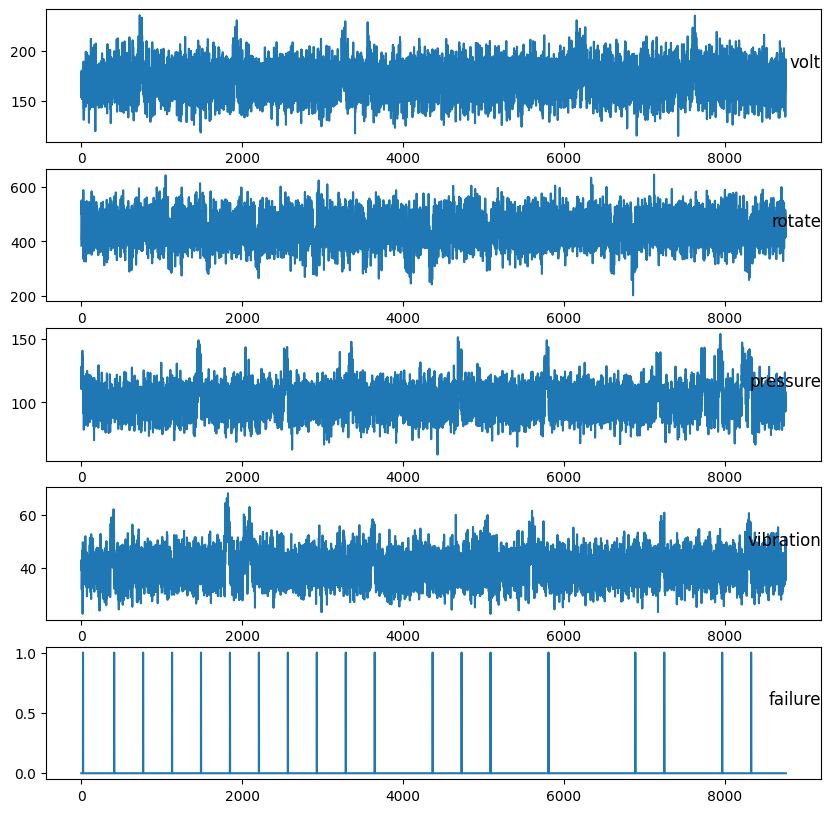

In [19]:
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure(figsize=(10,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(datos.values[:, group])
    plt.title(datos.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Convierte los datos en una forma adecuada para series de tiempo tipo [samples, timesteps, features]

In [20]:
MVSeries = datos.values
MVSeries.shape

(8761, 5)

In [21]:
def create_datasetMV(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back][-1])
    return np.array(dataX), np.array(dataY)

X_seq, y_seq = create_datasetMV(MVSeries, look_back=2)
X_seq.shape, y_seq.shape

((8759, 2, 5), (8759,))

Se define una funcion que nos entrega un modelo de red neuronal que soporte los 3 tipo comunes usados en series de tiempo: SimpleRNN, LSTM y GRU

In [22]:
def Recurrent_Model(X_train,layer_type='SimpleRNN'):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
    #X_train is used for setting input_shape dimensions
    print(X_train.shape)
    model = Sequential()
    if layer_type == 'SimpleRNN':
        model.add(SimpleRNN(20,activation = 'relu', return_sequences=True, input_shape=X_train.shape[1:]))
        model.add(SimpleRNN(20,activation = 'relu'))

    if layer_type == 'LSTM':
        model.add(LSTM(10, return_sequences=True, input_shape=X_train.shape[1:]))
        model.add(Dropout(0.4))
        model.add(LSTM(10))
        model.add(Dropout(0.4))

    if layer_type == 'GRU':
        model.add(GRU(10, return_sequences=True, input_shape=X_train.shape[1:]))
        model.add(Dropout(0.1))
        model.add(GRU(10))

    model.add(Dense(1))
    return model

Se define una funcion que retorna el dataset listo para usarno en el modelo. Esta funcion divide el dataset en entrenamiento y pruebas y usa la funcion que convierte los datos para series de tiempo [samples, timesteps, features]

In [23]:
def DataPreparation(MVSeries,look_back,create_datasetMV,groups):
	times = MVSeries.shape[0]
    # split into train and test sets
	train_size = int(times * 0.67)
	test_size = times - train_size
	train, test = MVSeries[0:train_size,groups], MVSeries[train_size-look_back:times,groups]
    # normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	trainN = scaler.fit_transform(train)
	testN = scaler.transform(test)
	X_train, y_train = create_datasetMV(trainN, look_back)
	X_test, y_test = create_datasetMV(testN, look_back)
    # Defino un scaler sólo para polución
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler.fit(train[:,0].reshape(-1,1))
	return X_train, y_train, X_test, y_test, scaler

Probamos y observamos las dimensiones de los datos preparados con 2 tiempos de observación hacia atras

In [24]:
look_back = 2
groups = [0, 1, 2, 3, 4]
X_train, y_train, X_test, y_test, scaler = DataPreparation(MVSeries,look_back,create_datasetMV,groups)

unique, counts = np.unique(y_train, return_counts=True)
print("Unique values:", unique)
print("Counts:", counts)

unique, counts = np.unique(y_test, return_counts=True)
print("Unique values:", unique)
print("Counts:", counts)

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

Unique values: [0. 1.]
Counts: [5852   15]
Unique values: [0. 1.]
Counts: [2888    4]


((5867, 2, 5), (5867,), (2892, 2, 5), (2892,))

In [25]:
def TrainModel(X_train,y_train,model):

    Optimi = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=Optimi,loss='binary_crossentropy',metrics=['accuracy'])
    stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    model.fit(X_train,y_train,epochs=20, validation_split=0.1, verbose=0, callbacks=[stop])
    return model

Se realiza el entrenamiento y prueba con los 3 modelos (SimpleRNN, LSTM y GRU) y 5 tiempos de observación

Serie:  1 Modelo:  LSTM
(5868, 1, 5)
91/91 [==============================] - 1s 2ms/step
RMSE: 0.04560457360579961
Serie:  1 Modelo:  GRU
(5868, 1, 5)
91/91 [==============================] - 1s 2ms/step
RMSE: 0.049445661551669774
Serie:  1 Modelo:  SimpleRNN
(5868, 1, 5)
91/91 [==============================] - 0s 2ms/step
RMSE: 0.11550969034745812
Serie:  2 Modelo:  LSTM
(5867, 2, 5)
91/91 [==============================] - 1s 2ms/step
RMSE: 0.09483499921986076
Serie:  2 Modelo:  GRU
(5867, 2, 5)
91/91 [==============================] - 1s 2ms/step
RMSE: 0.1684389143827169
Serie:  2 Modelo:  SimpleRNN
(5867, 2, 5)
91/91 [==============================] - 1s 3ms/step
RMSE: 0.2064947807191582
Serie:  3 Modelo:  LSTM
(5866, 3, 5)
91/91 [==============================] - 1s 2ms/step
RMSE: 0.072728761576339
Serie:  3 Modelo:  GRU
(5866, 3, 5)
91/91 [==============================] - 1s 2ms/step
RMSE: 0.3268776689077407
Serie:  3 Modelo:  SimpleRNN
(5866, 3, 5)
91/91 [====================

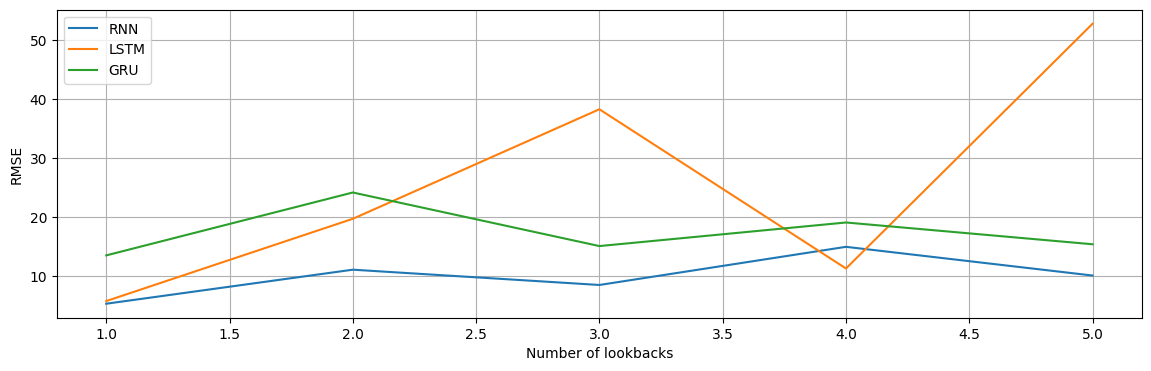

In [31]:
from local.lib.DataPreparationRNN import Plot_Task2
mse = np.zeros((3,5))
for i in range(1,6):
    X_train, y_train, X_test, y_test, scaler = DataPreparation(MVSeries,i,create_datasetMV,groups)
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        print("Serie: ",i,"Modelo: ",k)
        model = Recurrent_Model(X_train,layer_type=k)
        model = TrainModel(X_train,y_train,model)
        y_est = model.predict(X_test)
        print('RMSE:',np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))
Plot_Task2(mse)

Se realiza el entrenamiento y prueba con un solo modelo y un tiempo de observación con los dos mejores resultados de RMSE

In [32]:
look_back = 1
X_train, y_train, X_test, y_test, scaler = DataPreparation(MVSeries,look_back, create_datasetMV,groups)

Se ejecuta de nuevo el modelo LSTM con look_back=1

In [35]:
model = Recurrent_Model(X_train,layer_type='LSTM')
model = TrainModel(X_train,y_train,model)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))

(5868, 1, 5)
91/91 [==============================] - 1s 2ms/step
RMSE con los datos normalizados
0.040677470052338835


Se grafica la serie de tiempo predictora de entenamiento y de pruebas de forma escalonada usando LSTM.

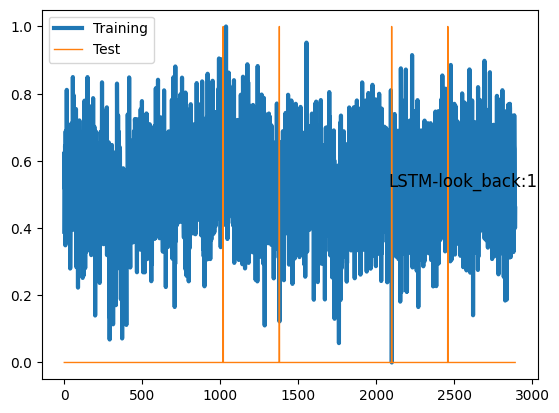

In [38]:
scaler = MinMaxScaler()

plt.title("LSTM-look_back:1", y=0.5, loc='right')
plt.plot(scaler.fit_transform(y_est), linewidth=3)
plt.plot(y_test, linewidth=1)
plt.legend(['Training', 'Test'])
plt.show()

Se ejecuta de nuevo el modelo RNN con look_back=1

In [41]:
model = Recurrent_Model(X_train,layer_type='SimpleRNN')
model = TrainModel(X_train,y_train,model)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))

(5868, 1, 5)
91/91 [==============================] - 0s 2ms/step
RMSE con los datos normalizados
0.2373992591604738


Se grafica la serie de tiempo predictora de entenamiento y de pruebas de forma escalada usando RNN.

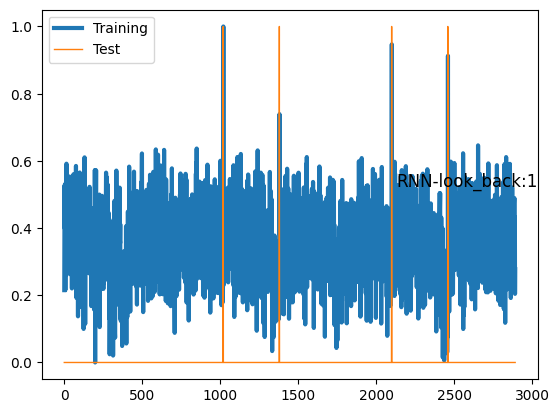

In [42]:
plt.title("RNN-look_back:1", y=0.5, loc='right')
plt.plot(scaler.fit_transform(y_est), linewidth=3)
plt.plot(y_test, linewidth=1)
plt.legend(['Training', 'Test'])
plt.show()